## Time Series Modelling 

Going through modelling process for:
* AR
* NNAR - Neural Network Auto Regressive
* MA
* ARIMA
* GARCH

Following (approx.) the Box-Jenkins methodology: (1) selecting models. (2) selecting order. (3) fitting parameters. (4) examining fit. (5) forecasting.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from numpy.linalg import inv
from scipy.optimize import minimize

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

### 1. Data Formatting

In [2]:
df = pd.read_csv('data/sealevel.csv')
df.head()

,Altimeter type,Merged file cycle nr,Year,Nr observations,Weighted nr observations,GMSL,GMSL std,GMSL smooth,GIA,GIA std,GIA smooth,GIA smooth cycle removed
0,0.0,11.0,1993.011526,466462.0,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0.0,12.0,1993.038692,460889.0,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
2,0.0,13.0,1993.065858,472123.0,342416.09,-40.17,92.29,-38.28,-40.16,92.29,-38.27,-37.60
3,0.0,14.0,1993.093025,421377.0,306050.59,-41.92,96.20,-38.56,-41.89,96.19,-38.54,-37.45
4,0.0,15.0,1993.120191,459548.0,331094.09,-36.89,94.64,-37.87,-36.85,94.63,-37.83,-36.44


In [3]:
df.set_index("Year", inplace=True)
df = df[["GMSL"]]
df.head()

,GMSL
Year,
1993.011526,-37.24
1993.038692,-40.35
1993.065858,-40.17
1993.093025,-41.92
1993.120191,-36.89


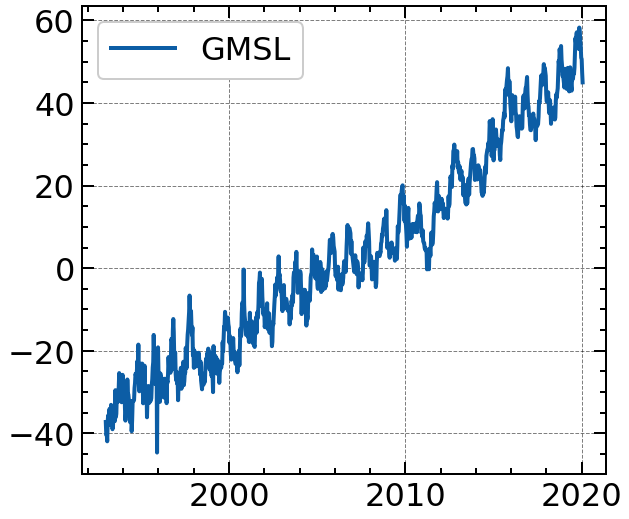

In [4]:
fig, ax = plt.subplots()
ax.plot(df.index, df["GMSL"])
ax.legend(["GMSL"])
fig.set_size_inches(4.7, 4.3)
plt.show()

Detring by assuming a linear trend. This is fitted by a linear regression model: $Y_t = \beta_0 + \beta_1 t + Z_t$, $Z \overset{\text{iid}}{\sim} N(0, \sigma^2)$. Writing the model as $\mathbf{Y} = \mathbf{X\beta} + \mathbf{Z}$ we solve the normal equations to obtain the approriate solution (can be solved with QR decomposition for increased numerical stability). Thus $\hat{\mathbf{\beta}}_{\text{OLS}} = (\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{Y}$.

In [5]:
number_of_observations = len(df)
Y = np.array(df["GMSL"])
X = np.stack([np.ones(number_of_observations), np.array(df.index)]).T
beta = inv((X.T @ X)) @ X.T @ Y

In [6]:
def trend(t: np.array, beta: np.array = beta) -> np.array:
    n = len(t)
    H = np.stack([np.ones(n), t]).T
    return H @ beta

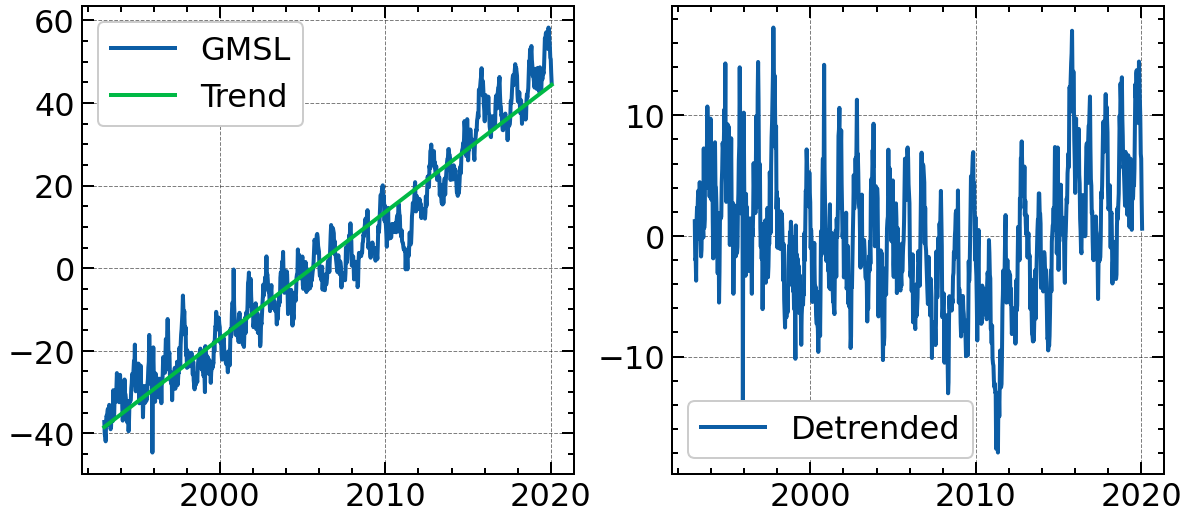

In [7]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df.index, df["GMSL"])
ax[0].plot(df.index, trend(df.index))
ax[0].legend(["GMSL", "Trend"])
ax[1].plot(df.index, df["GMSL"]-trend(df.index))
ax[1].legend(["Detrended"])
fig.set_size_inches(9.7, 4.3)
plt.show()

In [8]:
df_training = (df["GMSL"]-trend(df.index)).iloc[:700]
df_validation = (df["GMSL"]-trend(df.index)).iloc[700:]

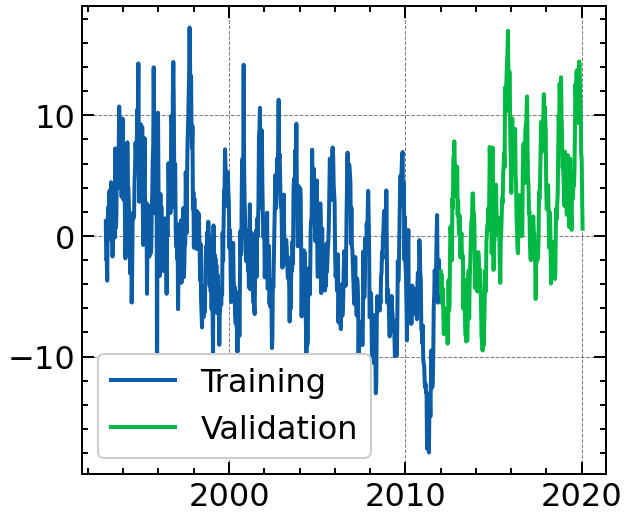

In [9]:
fig, ax = plt.subplots()
ax.plot(df.index[:700], df_training)
ax.plot(df.index[700:], df_validation)
ax.legend(["Training", "Validation"])
fig.set_size_inches(4.7, 4.3)
plt.show()

### 2. Autoregressive Models

In [10]:
def fit_ar_model(data: np.array, lag: int) -> np.array:
    number_of_observations = len(data)
    if lag > number_of_observations:
        raise ValueError
    
    # build Y matrix.
    Y = data[lag:]

    # build X matrix.
    X = []
    for i in range(lag):
        X.append(data[lag-i-1:number_of_observations-i-1])
    X = np.stack(X).T
    
    # solve normal equations.
    phi = inv(X.T @ X) @ X.T @ Y
    return phi       

In [11]:
phi = fit_ar_model(data=np.array(df_training), lag=10)
phi

array([ 0.62156052,  0.10763277,  0.15104657,  0.1745703 , -0.02184709,
       -0.05955406, -0.09578106,  0.07585221, -0.11175939,  0.02305208])

In [12]:
def step_prediction(phi: np.array, data: np.array) -> np.array:
    lag = len(phi)
    number_of_observations = len(data)
    X = []
    for i in range(lag):
        X.append(data[lag-i-1:number_of_observations-i-1])
    X = np.stack(X).T
    return X @ phi

In [13]:
one_step_predictions = step_prediction(phi, np.array(df_training))

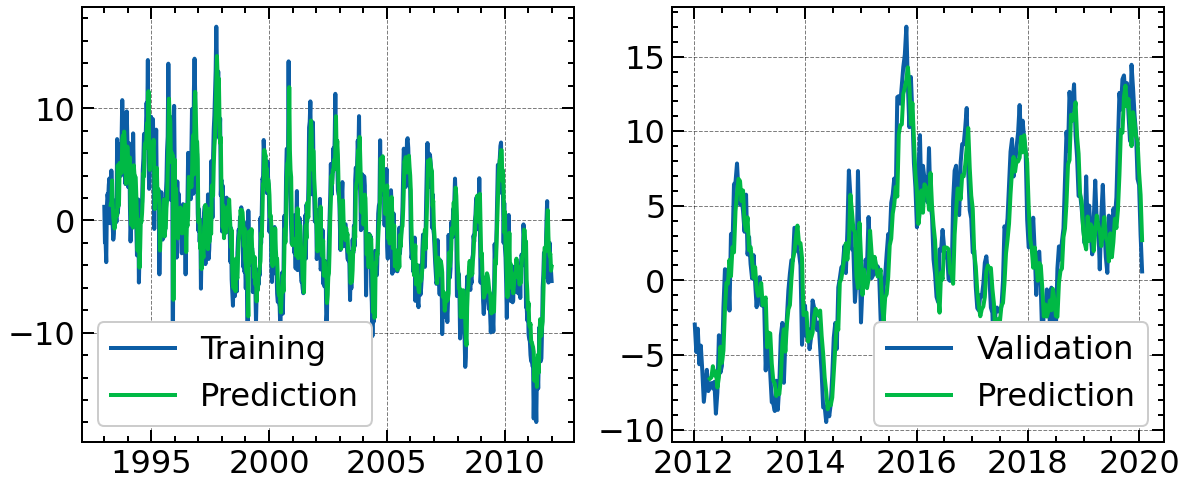

In [14]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df.index[:700], np.array(df_training))
ax[0].plot(df.index[10:700], one_step_predictions)
ax[0].legend(["Training", "Prediction"])

ax[1].plot(df.index[700:], np.array(df_validation))
ax[1].plot(df.index[710:], np.array(step_prediction(phi, np.array(df_validation))))
ax[1].legend(["Validation", "Prediction"])
fig.set_size_inches(9.7, 4,3)
plt.show()

Checking the residuals w.r.t the training data. Assuming our model is correct, the residuals should resemble Gaussian WN.

In [15]:
residuals = np.array(df_training)[10:] - one_step_predictions
residuals_test = np.array(df_validation)[10:] - step_prediction(phi, np.array(df_validation))

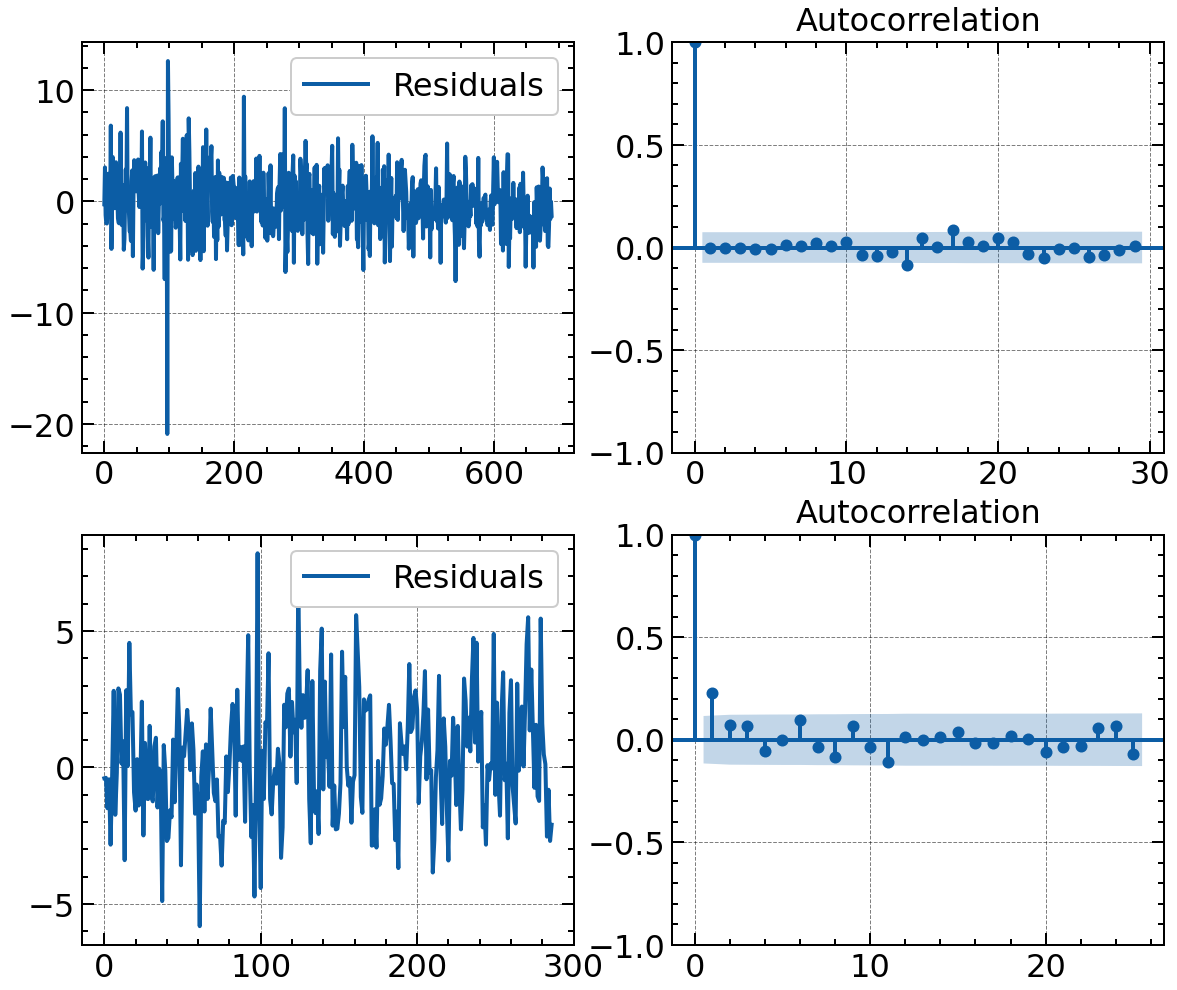

In [16]:
fig, ax = plt.subplots(2, 2)
ax[0,0].plot(residuals)
ax[0,0].legend(["Residuals"])
plot_acf(residuals, ax=ax[0,1])

ax[1,0].plot(residuals_test)
ax[1,0].legend(["Residuals"])
plot_acf(residuals_test, ax=ax[1,1])
fig.set_size_inches(9.7, 8.3)
plt.show()

In [17]:
def mse(data: np.array, predictions: np.array) -> np.array:
    if len(data) != len(predictions):
        raise ValueError
    constant_factor = 1 / len(data)
    return constant_factor * (data - predictions).T @ (data-predictions)

In [18]:
training_mse = []
validation_mse = []
lags = range(1,150)

for p in lags:
    phi = fit_ar_model(np.array(df_training), p)
    test_prediction = step_prediction(phi, np.array(df_training))
    vald_prediction = step_prediction(phi, np.array(df_validation))
    training_mse.append(mse(np.array(df_training)[p:], test_prediction))
    validation_mse.append(mse(np.array(df_validation)[p:], vald_prediction))

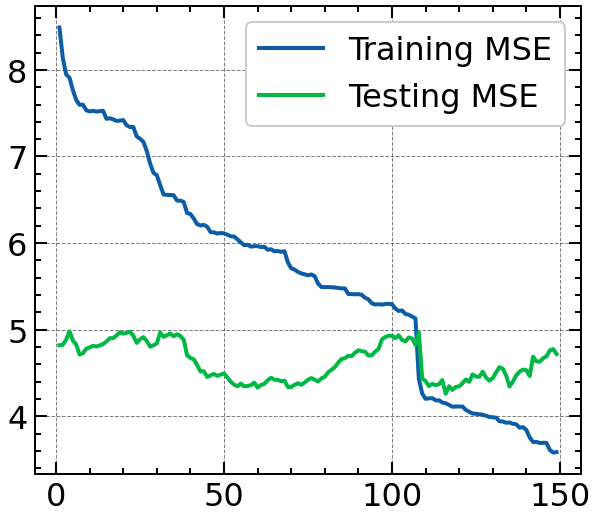

In [19]:
fig, ax = plt.subplots()
ax.plot(lags, training_mse)
ax.plot(lags, validation_mse)
ax.legend(["Training MSE", "Testing MSE"])
fig.set_size_inches(4.9, 4.3)
plt.show()

In [20]:
optimal_lag = np.argsort(validation_mse)[2]
optimal_phi = fit_ar_model(np.array(df_training), optimal_lag)

The optimal_lag had to be adjusted for not being stationary. Hence the thrid optimal lag chosen. For longer term predictions, we start to see poor performance from the model. 

In [21]:
def n_step_prediction(steps: int, phi: np.array, predictor_data: np.array) -> np.array:
    lags = len(phi)
    predictions = np.zeros(steps)
    for i in range(steps):
        predicted_value = phi.T @ predictor_data
        predictions[i] = predicted_value
        predictor_data = np.insert(predictor_data, 0, predicted_value)[:-1]
        
    return predictions

In [22]:
initial_predictor_data = np.array(df_training)[len(np.array(df_training))-optimal_lag:]
n_steps = len(np.array(df_validation))
n_step_predictions = n_step_prediction(n_steps, optimal_phi, initial_predictor_data)

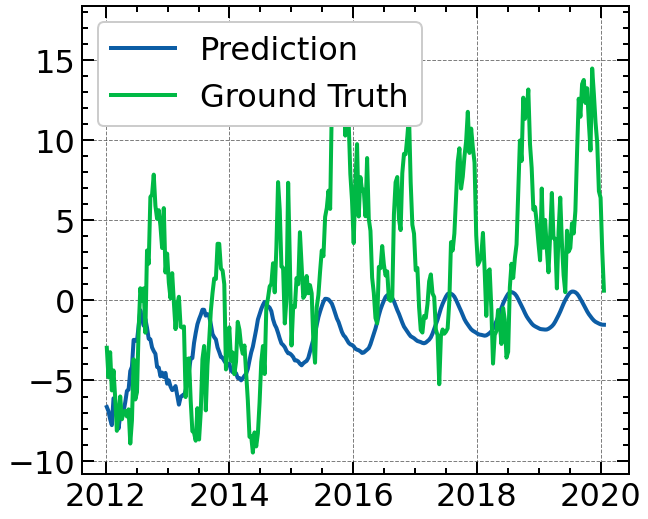

In [23]:
fig, ax = plt.subplots()
ax.plot(df.index[700:], n_step_predictions)
ax.plot(df_validation)
ax.legend(["Prediction", "Ground Truth",])
fig.set_size_inches(4.9, 4.3)
plt.show()

In [24]:
long_forcast_steps = 2000
long_predictions = n_step_prediction(long_forcast_steps, optimal_phi, initial_predictor_data)

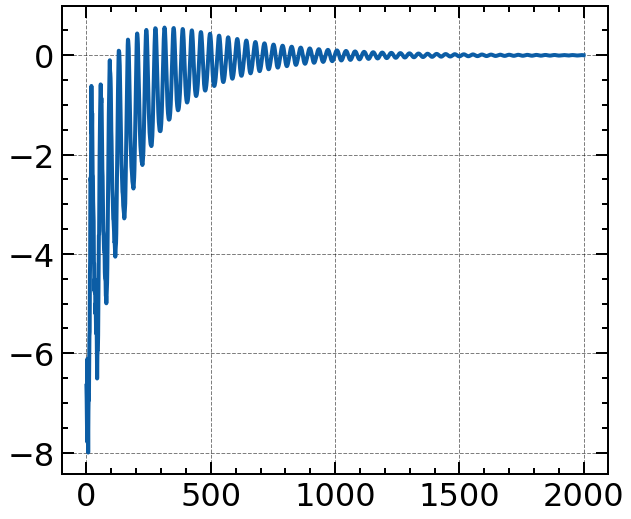

In [25]:
fig, ax = plt.subplots()
ax.plot(long_predictions)
fig.set_size_inches(4.9, 4.3)
plt.show()

In [26]:
import torch
import torch.nn as nn

In [27]:
class Net(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.loss = nn.MSELoss()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(p, 18)
        self.fc4 = nn.Linear(18, 1)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc4(x)
        return x

net = Net(optimal_lag)
print(net)

Net(
  (loss): MSELoss()
  (relu): ReLU()
  (fc1): Linear(in_features=59, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=1, bias=True)
)


In [28]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [29]:
training_data = np.array(df_training)
training_observations = len(training_data)
lag = optimal_lag

output_data = training_data[lag:]
input_data = []
for i in range(lag):
    input_data.append(training_data[lag-i-1:training_observations-i-1])
input_data = np.stack(input_data).T

In [30]:
output_data = torch.Tensor(output_data)
input_data = torch.Tensor(input_data)

In [31]:
for i in range(training_observations-lag):
    X = input_data[i,:lag]
    y = output_data[i].view(1)
    net.zero_grad()
    output = net.forward(X)
    loss = net.loss(output, y)
    loss.backward()
    optimizer.step()

Setting the neural network in evaluation mode.

In [32]:
net.eval()

Net(
  (loss): MSELoss()
  (relu): ReLU()
  (fc1): Linear(in_features=59, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=1, bias=True)
)

Transforming test data into tensor format.

In [33]:
testing_data = np.array(df_validation)
testing_observations = len(testing_data)
lag = optimal_lag

test_output_data = testing_data[lag:]
test_input_data = []
for i in range(lag):
    test_input_data.append(testing_data[lag-i-1:testing_observations-i-1])
test_input_data = np.stack(test_input_data).T
test_output_data = torch.Tensor(test_output_data)
test_input_data = torch.Tensor(test_input_data)

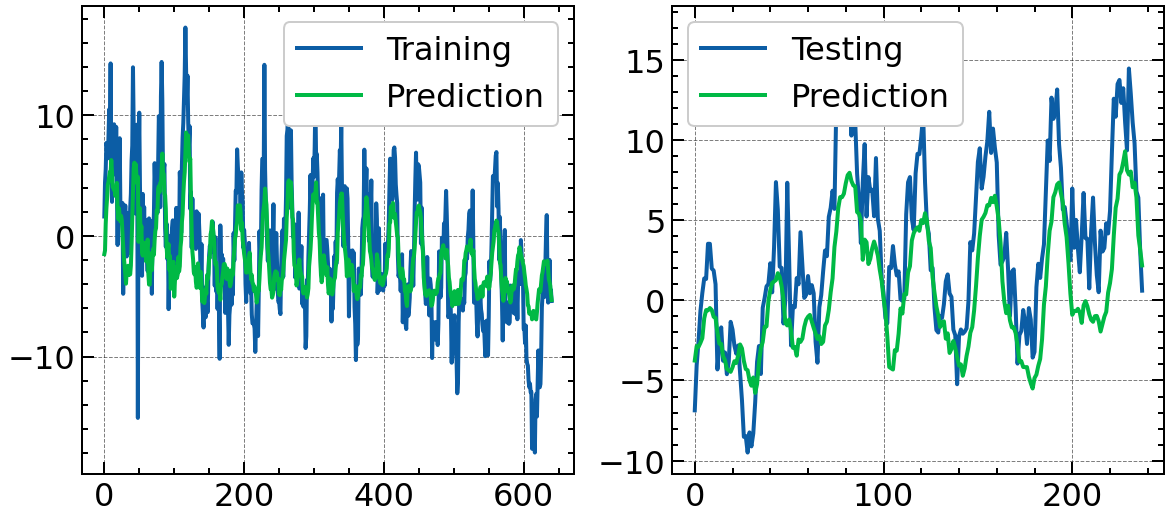

In [34]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.array(output_data[:].detach().numpy()))
ax[0].plot(np.array(net(input_data[:,:lag]).detach().numpy()))
ax[0].legend(["Training", "Prediction"])
ax[1].plot(np.array(test_output_data[:].detach().numpy()))
ax[1].plot(np.array(net(test_input_data[:,:lag]).detach().numpy()))
ax[1].legend(["Testing", "Prediction"])
fig.set_size_inches(9.7, 4.3)
plt.show()

### 3. Moving Average Models

Applying a MA(q) process to the detrended sea-level data, to examine its properties. We begin by assuming a lag of one, $q=3$, before moving on to the general case.

In [35]:
def log_loss_q(params: np.array, data: np.array, lag: int) -> float:
    loss = 0.0
    z = np.zeros(lag)
    sigma = params[0]
    theta = params[1:]
    number_of_observations = len(data)
    for i in range(lag, number_of_observations):
        loss += ((data[i]- (theta.T @ z))/sigma) ** 2  
        new_z = data[i] - theta.T @ z
        z = np.insert(z[:-1], 0, new_z)
    return loss + number_of_observations * np.log(sigma**2)

In [36]:
init_params = np.array([np.std(df_training), 0.0, 0.0, 0.0])
data = np.array(df_training)
lags=3

In [72]:
thetas = minimize(log_loss_q, init_params, args=(data, lags), method="Nelder-Mead").x[1:]

In [73]:
def ma_1_step_prediction(theta: np.array, data: np.array) -> np.array:
    lag = len(theta)
    z = np.zeros(lag)
    predictions = []
    number_of_observations = len(data)
    for i in range(lag, number_of_observations):
        prediction = theta.T @ z
        predictions.append(prediction)
        new_z = data[i] - theta.T @ z
        z = np.insert(z[:-1], 0, new_z)
    return np.array(predictions)

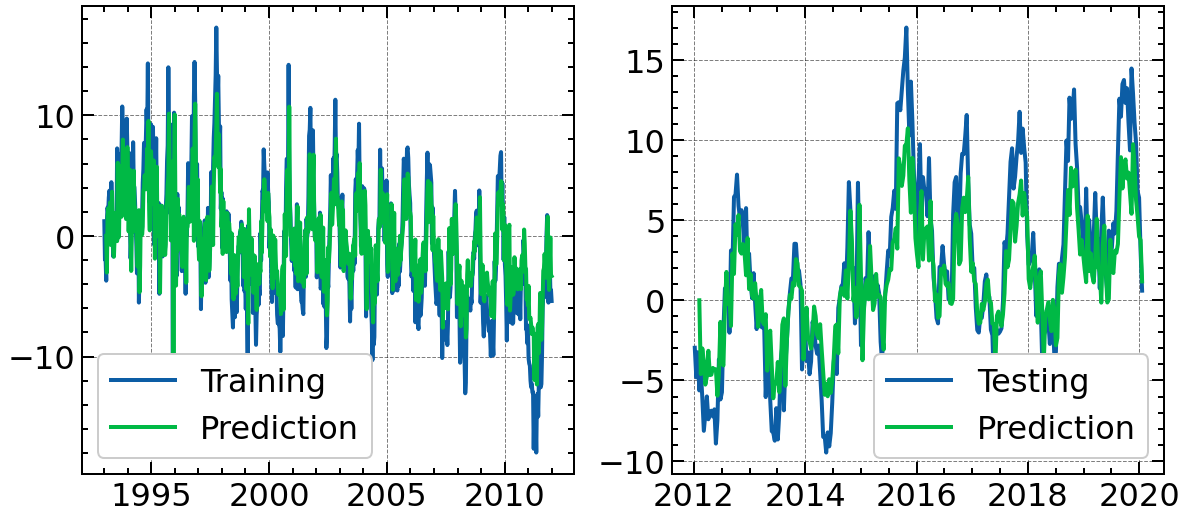

In [74]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(df.index[:700], np.array(df_training))
ax[0].plot(df.index[3:700], ma_1_step_prediction(thetas, data))
ax[0].legend(["Training", "Prediction"])
ax[1].plot(df.index[700:], np.array(df_validation))
ax[1].plot(df.index[700+3:], ma_1_step_prediction(thetas, np.array(df_validation)))
ax[1].legend(["Testing", "Prediction"])
fig.set_size_inches(9.7, 4.3)
plt.show()

### 4. ARIMA Models

Assuming we have already differentiated the time series (differencing of order 1 or 2) we can continue to model the sea level data as an ARMA process. We try three sets of combinations $(p,q) = (6,3)$, $(p,q) = (6,6)$ and $(p,q) = (3,6)$

In [44]:
def _arma_log_loss(params: np.array, data: np.array, p: int, q: int) -> float:
    """
    Calculates conditional log loss based on Hamilton. 
    """
    number_of_observations = len(data)
    phi = params[:p]
    theta = params[p:p+q]
    sigma = params[p+q:]
    loss = 0
    z = np.zeros(q)
    y = data[:p]

    for i in range(p+1, number_of_observations):
        residual = data[i] - phi.T @ y - theta.T @ z
        loss += residual ** 2
        z = np.insert(z[:-1], 0, residual)
        y = np.insert(y[:-1], 0, data[i])
    return (1 / (sigma ** 2) * loss + (number_of_observations-p) * np.log(sigma**2))

In [67]:
def fit_arma_model(data: np.array, p: int, q: int) -> np.array:
    init_params = np.ones(p+q)*0
    init_params = np.insert(init_params, len(init_params), np.std(data))
    solution = minimize(_arma_log_loss, init_params, args=(data, p , q), method='nelder-mead')
    print(solution.success)
    return solution.x

In [68]:
def arma_1_step_prediction(params: np.array, data: np.array, p: int, q: int):
    phi = params[:p]
    theta = params[p:p+q]
    number_of_observations = len(data)
    z = np.zeros(q)
    y = data[:p]
    predictions = []
    for i in range(p+1, number_of_observations):
        residual = data[i] - phi.T @ y - theta.T @ z
        predictions.append(phi.T @ y + theta.T @ z)
        z = np.insert(z[:-1], 0, residual)
        y = np.insert(y[:-1], 0, data[i])
    return np.array(predictions)

In [69]:
arma_params_66 = fit_arma_model(np.array(df_training), 6, 6)
arma_params_63 = fit_arma_model(np.array(df_training), 6, 3)
arma_params_36 = fit_arma_model(np.array(df_training), 3, 6)

False
True
False


In [70]:
arma_predictions_training_66 = arma_1_step_prediction(arma_params_66, np.array(df_training), 6, 6)
arma_predictions_testing_66 = arma_1_step_prediction(arma_params_66, np.array(df_validation), 6, 6)
arma_predictions_training_63 = arma_1_step_prediction(arma_params_63, np.array(df_training), 6, 3)
arma_predictions_testing_63 = arma_1_step_prediction(arma_params_63, np.array(df_validation), 6, 3)
arma_predictions_training_36 = arma_1_step_prediction(arma_params_36, np.array(df_training), 3, 6)
arma_predictions_testing_36 = arma_1_step_prediction(arma_params_36, np.array(df_validation), 3, 6)

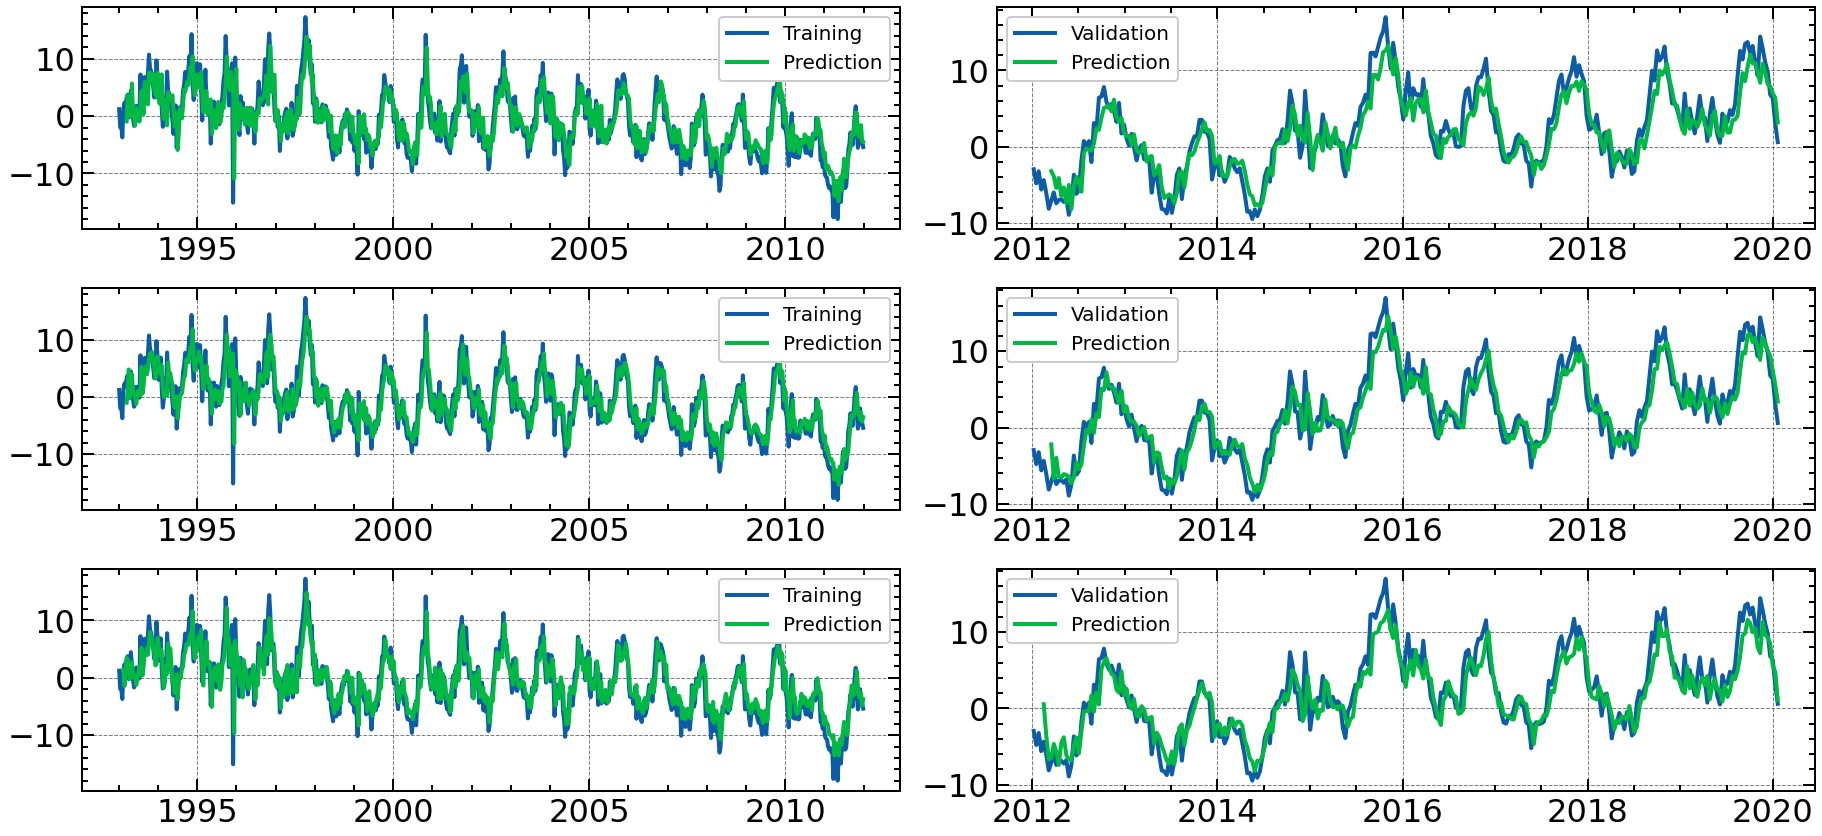

In [71]:
fig, ax = plt.subplots(3, 2)
ax[0, 0].plot(df.index[:700], np.array(df_training))
ax[0, 0].plot(df.index[7:700], arma_predictions_training_66)
ax[0, 0].legend(["Training", "Prediction"], prop={'size': 10})
ax[0, 1].plot(df.index[700:], np.array(df_validation))
ax[0, 1].plot(df.index[700+7:], arma_predictions_testing_66)
ax[0, 1].legend(["Validation", "Prediction"], prop={'size': 10})

ax[1, 0].plot(df.index[:700], np.array(df_training))
ax[1, 0].plot(df.index[7:700], arma_predictions_training_63)
ax[1, 0].legend(["Training", "Prediction"], prop={'size': 10})
ax[1, 1].plot(df.index[700:], np.array(df_validation))
ax[1, 1].plot(df.index[700+7:], arma_predictions_testing_63)
ax[1, 1].legend(["Validation", "Prediction"], prop={'size': 10})

ax[2, 0].plot(df.index[:700], np.array(df_training))
ax[2, 0].plot(df.index[3+1:700], arma_predictions_training_36)
ax[2, 0].legend(["Training", "Prediction"], prop={'size': 10})
ax[2, 1].plot(df.index[700:], np.array(df_validation))
ax[2, 1].plot(df.index[700+3+1:], arma_predictions_testing_36)
ax[2, 1].legend(["Validation", "Prediction"], prop={'size': 10})

fig.set_size_inches(12.9, 6)
plt.tight_layout()
plt.show()

### 5. ARIMA-GARCH Models

In [187]:
def arma_garch_log_loss(params: np.array, data: np.array, p: int, q: int) -> float:
    # throw errors if p, q larger than data set and dataset is smaller than needed for good init vol estimate.
    number_of_observations = len(data)
    residuals = np.zeros(number_of_observations - p - 1)
    volatility_squared = np.zeros(number_of_observations - p - 1)



    # Mean init.
    phi = params[2:p+2]
    theta = params[p+2:p+q+2]
    z = np.zeros(q)
    y = data[:p]

    # Volatility init.
    vol_squared = np.std(data) ** 2
    p1 = params[0]
    p2 = params[1]
    long_run_vol = np.std(data) ** 2
    



    for i in range(p+1, number_of_observations):
        residual = data[i] - (phi.T @ y + theta.T @ z)
        mu_corr = np.exp(-np.exp(-params[0]))
        mu_ewma = np.exp(-np.exp(-params[1]))
        vol_squared = long_run_vol + mu_corr * (
                    mu_ewma * vol_squared
                    + (1 - mu_ewma) * z[0] ** 2
                    - long_run_vol
                )
        z = np.insert(z[:-1], 0, residual)
        y = np.insert(y[:-1], 0, data[i])
        
        residuals[i-p-1] = residual
        volatility_squared[i-p-1] = vol_squared
    


    loss = np.sum(residuals ** 2 / volatility_squared + np.log(volatility_squared+1e-6))
    return loss

In [224]:
def precondition_parameters(params: np.array) -> np.array:
    mu_corr = params[0] + params[1]
    mu_ewma = params[1] / (params[0] + params[1])

    z_corr = np.log(-1 / np.log(mu_corr))
    z_ewma = np.log(-1 / np.log(mu_ewma))

    return np.array([z_corr, z_ewma])

def fit_arma_garch_model(x0, data, p, q):
    initial_garch_sol = np.array([0.05, 0.80])
    initial_garch_sol = precondition_parameters(initial_garch_sol)
    x0 = np.insert(x0, 0, initial_garch_sol)
    print(x0)
    solution = minimize(arma_garch_log_loss, x0=x0, args=(data, p, q), method="trust-constr")
    print(solution.success)
    return solution.x

In [225]:
test_params = np.ones(9)*0.25

In [221]:
sol = fit_arma_garch_model(test_params, np.array(df_training), 6, 3)
sol

[1.81696079 2.80305417 0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25      ]
True


array([ 5.50510203,  2.33846055,  0.76373742,  0.57886065, -0.50374724,
        0.26638927, -0.08889851, -0.09713081, -0.09967562, -0.53512147,
        0.30162203])

In [222]:
def _uncondition_parameters(params: np.array) -> np.array:
    mu_corr = np.exp(-np.exp(-params[0]))
    mu_ewma = np.exp(-np.exp(-params[1]))

    alpha = mu_corr * (1 - mu_ewma)
    beta = mu_corr * mu_ewma

    return np.array([alpha, beta])


In [223]:
_uncondition_parameters(sol[:2])

array([0.09159517, 0.90434711])